In [103]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T
from torchvision import models, transforms
from sklearn.preprocessing import MultiLabelBinarizer
import pandas as pd
import numpy as np
from tqdm import tqdm


In [104]:
import os
import json
import pandas as pd

label_dir = r"Dataset_info\Label"
base_audio_dir = r"Dataset_info\Dataset"

# Count all .mp3 files across profane and non_profane folders
all_mp3_files = []
for sub in ["profane", "non_profane"]:
    sub_dir = os.path.join(base_audio_dir, sub)
    all_mp3_files.extend([
        os.path.join(sub, f) for f in os.listdir(sub_dir) if f.endswith(".mp3")
    ])
print(f"🎧 Total .mp3 files in folder: {len(all_mp3_files)}")

# Load all JSON annotations in the label folder
label_paths = [os.path.join(label_dir, f) for f in os.listdir(label_dir) if f.endswith(".json")]
print(f" Total annotation files found: {len(label_paths)}")

records = []
all_label_names = set()
missing = 0

# Load and parse each label file
for path in label_paths:
    with open(path, "r") as f:
        annotations = json.load(f)

    print(f"🔍 Loading {path} with {len(annotations)} entries")

    for item in annotations:
        original = os.path.basename(item["audio"])  # e.g., b9c19d19-3497_profane.mp3
        number_suffix = original.split("-")[-1]      # → 3497_profane.mp3
        full_path = os.path.join(base_audio_dir, "profane", number_suffix)

        labels = []
        for seg in item["label"]:
            labels.extend(seg["labels"])
        unique_labels = list(set(labels))
        all_label_names.update(unique_labels)

        if os.path.exists(full_path):
            records.append({
                "audio": full_path,
                "labels": unique_labels
            })
        else:
            print(f"⚠️ Missing: {full_path}")
            missing += 1

# Add non-profane files from non_profane folder with empty labels
non_profane_dir = os.path.join(base_audio_dir, "non_profane")
non_profane_files = [f for f in os.listdir(non_profane_dir) if f.endswith(".mp3")]

for f in non_profane_files:
    full_path = os.path.join(non_profane_dir, f)
    records.append({
        "audio": full_path,
        "labels": []  # empty label = clean
    })

print(f"Added {len(non_profane_files)} clean (non-profane) audio clips.")

# Create DataFrame
df = pd.DataFrame(records)

# Count clean samples (empty label list)
num_clean = df['labels'].apply(lambda x: len(x) == 0).sum()

# Summary
print(f"\nTotal audio clips (labeled + clean): {len(df)}")
print(f"Missing profane files: {missing}")
print(f"Clean (non-profane) audio clips: {num_clean}")
print(f"Unique labels (from profane set): {sorted(list(all_label_names))}")
print(f" Total number of unique labels: {len(all_label_names)}")

🎧 Total .mp3 files in folder: 1700
 Total annotation files found: 2
🔍 Loading Dataset_info\Label\chamak.json with 450 entries
🔍 Loading Dataset_info\Label\shahrior.json with 457 entries
Added 800 clean (non-profane) audio clips.

Total audio clips (labeled + clean): 1707
Missing profane files: 0
Clean (non-profane) audio clips: 800
Unique labels (from profane set): ['TVFOURTEEN', 'TVMA', 'TVYSEVEN']
 Total number of unique labels: 3


In [106]:
# Converts text labels into binary vectors.

mlb = MultiLabelBinarizer()
df["encoded_labels"] = mlb.fit_transform(df["labels"]).tolist()
label2idx = {label: idx for idx, label in enumerate(mlb.classes_)}
num_classes = len(label2idx)

In [108]:
import torchaudio
import torch
from torch.utils.data import Dataset
from torchaudio import transforms as T
import torch.nn.functional as F

class AudioMelDataset(Dataset):
    def __init__(self, df, sample_rate=16000, n_mels=64, fixed_length=224):
        self.df = df
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.fixed_length = fixed_length
        self.resample = T.Resample(orig_freq=44100, new_freq=sample_rate)
        self.mel = T.MelSpectrogram(sample_rate=sample_rate, n_mels=n_mels)
        self.to_db = T.AmplitudeToDB()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_path = row["audio"]

        try:
            waveform, sr = torchaudio.load(file_path)
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")
            # Return dummy data if file can't be loaded
            dummy_input = torch.zeros(3, self.n_mels, self.fixed_length)
            dummy_label = torch.tensor(row["encoded_labels"], dtype=torch.float32)
            return dummy_input, dummy_label

        if sr != self.sample_rate:
            waveform = self.resample(waveform)

        mel_spec = self.to_db(self.mel(waveform))  # [1, 64, time]
        mel_spec = mel_spec.squeeze(0)             # [64, time]

        # Pad or truncate along time dimension
        if mel_spec.shape[1] < self.fixed_length:
            pad_width = self.fixed_length - mel_spec.shape[1]
            mel_spec = F.pad(mel_spec, (0, pad_width))
        else:
            mel_spec = mel_spec[:, :self.fixed_length]

        mel_spec = mel_spec.unsqueeze(0).repeat(3, 1, 1)  # [3, 64, 224]

        label = torch.tensor(row["encoded_labels"], dtype=torch.float32)
        return mel_spec, label


In [109]:
# Create full dataset
full_dataset = AudioMelDataset(df)

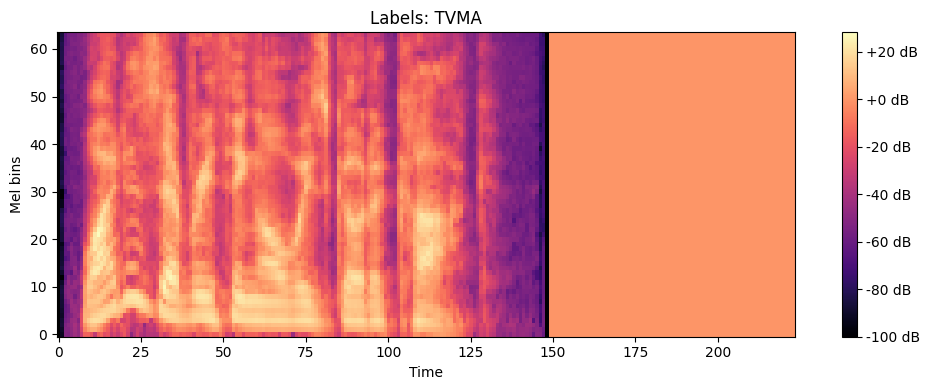

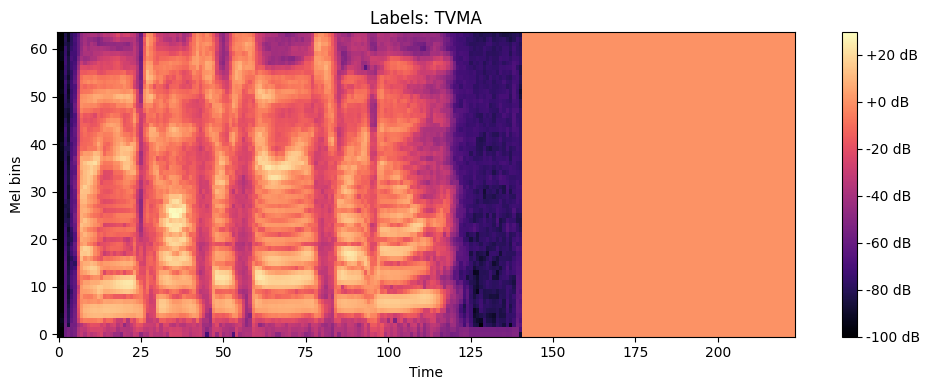

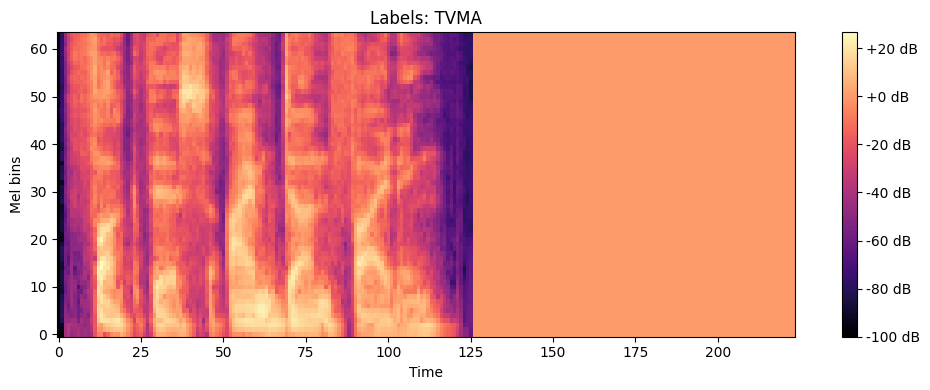

In [118]:
import matplotlib.pyplot as plt
import random

# Pick a few random indices from dataset
n_samples = 3
indices = random.sample(range(len(full_dataset)), n_samples)

for i in indices:
    mel_spec, label_tensor = full_dataset[i]
    label_indices = (label_tensor > 0.5).nonzero(as_tuple=True)[0].tolist()
    label_names = [mlb.classes_[j] for j in label_indices]

    # Plot
    plt.figure(figsize=(10, 4))
    plt.imshow(mel_spec[0].cpu().numpy(), origin='lower', aspect='auto', cmap='magma')
    plt.title(f"Labels: {' | '.join(label_names)}")
    plt.colorbar(format="%+2.0f dB")
    plt.xlabel("Time")
    plt.ylabel("Mel bins")
    plt.tight_layout()
    plt.show()


In [119]:
from torch.utils.data import random_split

full_dataset = AudioMelDataset(df)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)


In [120]:
resnet = models.resnet18(pretrained=True)
resnet.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)


In [ ]:
# CHAMAK

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-4)

for epoch in range(10):  # adjust as needed
    resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = resnet(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct += (predicted == targets).sum().item()
        total += targets.numel()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

100%|██████████| 86/86 [01:59<00:00,  1.39s/it]


Epoch 1, Loss: 0.4642, Accuracy: 77.66%


100%|██████████| 86/86 [01:15<00:00,  1.14it/s]


Epoch 2, Loss: 0.2705, Accuracy: 88.25%


100%|██████████| 86/86 [01:05<00:00,  1.31it/s]


Epoch 3, Loss: 0.1460, Accuracy: 95.19%


100%|██████████| 86/86 [01:11<00:00,  1.21it/s]


Epoch 4, Loss: 0.0739, Accuracy: 98.02%


100%|██████████| 86/86 [01:07<00:00,  1.27it/s]


Epoch 5, Loss: 0.0480, Accuracy: 98.95%


100%|██████████| 86/86 [01:03<00:00,  1.36it/s]


Epoch 6, Loss: 0.0633, Accuracy: 98.34%


100%|██████████| 86/86 [01:00<00:00,  1.42it/s]


Epoch 7, Loss: 0.0562, Accuracy: 98.46%


100%|██████████| 86/86 [01:00<00:00,  1.42it/s]


Epoch 8, Loss: 0.0483, Accuracy: 98.56%


100%|██████████| 86/86 [01:00<00:00,  1.42it/s]


Epoch 9, Loss: 0.0366, Accuracy: 98.97%


100%|██████████| 86/86 [01:02<00:00,  1.38it/s]

Epoch 10, Loss: 0.0357, Accuracy: 99.02%


In [ ]:
# Do Not RUN

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-4)

for epoch in range(20):  # adjust as needed
    resnet.train()
    running_loss = 0.0
    for inputs, targets in tqdm(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = resnet(inputs)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")

In [ ]:
torch.save(resnet.state_dict(), "resnet_18_with_profane_nonProfane.pth")

In [147]:
import torchaudio
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torchaudio import transforms as T


def merge_overlapping_intervals_with_labels(intervals, gap=0.05):
    """Merge intervals and keep track of the most frequent class label."""
    if not intervals:
        return []
    intervals.sort(key=lambda x: x[0])  # sort by start time
    merged = [intervals[0]]
    for curr in intervals[1:]:
        last = merged[-1]
        if curr[0] <= last[1] + gap:
            merged[-1] = (
                last[0],
                max(last[1], curr[1]),
                last[2] if last[2] == curr[2] else f"{last[2]}/{curr[2]}",
            )
        else:
            merged.append(curr)
    return merged


def visualize_profane_regions(
    audio_path,
    model_path="resnet_18_with_profane_nonProfane.pth",
    window_size_sec=0.25,
    stride_sec=0.25,
    threshold=0.6,
):
    resnet.load_state_dict(torch.load(model_path, map_location=device))
    resnet.eval()

    waveform, sr = torchaudio.load(audio_path)
    waveform = waveform[0]  # mono
    total_samples = waveform.shape[0]
    duration_sec = total_samples / sr

    window_size = int(window_size_sec * sr)
    stride = int(stride_sec * sr)

    detected_regions = []  # (start, end, label)

    for start in range(0, total_samples - window_size + 1, stride):
        end = start + window_size
        window = waveform[start:end].unsqueeze(0)
        if window.shape[-1] < 512:
            continue

        mel = T.MelSpectrogram(sample_rate=sr, n_mels=64)(window)
        mel = T.AmplitudeToDB()(mel).squeeze(0)
        mel = F.pad(mel, (0, max(0, 224 - mel.shape[1])))[:, :224]
        mel = mel.unsqueeze(0).repeat(3, 1, 1).unsqueeze(0).to(device)

        with torch.no_grad():
            probs = torch.sigmoid(resnet(mel)).cpu().numpy()[0]

        for i, p in enumerate(probs):
            label = mlb.classes_[i]
            if label in {"TVMA", "TVFOURTEEN", "TVYSEVEN"} and p > threshold:
                detected_regions.append((start / sr, end / sr, label))
                break

    # Merge overlapping with labels
    merged_regions = merge_overlapping_intervals_with_labels(detected_regions, gap=0.05)

    # Filter short or too-early segments
    merged_regions = [r for r in merged_regions if (r[1] - r[0]) >= 0.2 and r[0] > 0.1]

    if merged_regions:
        print("Final Profane Regions (seconds):")
        for r in merged_regions:
            print(f"  {r[0]:.2f}s → {r[1]:.2f}s   Label: {r[2]}")
    else:
        print("No profanity detected.")

    # Plot
    plt.figure(figsize=(14, 3))
    time_axis = np.linspace(0, duration_sec, total_samples)
    plt.plot(time_axis, waveform.cpu().numpy(), alpha=0.7)

    for start, end, label in merged_regions:
        plt.axvspan(start, end, color="red", alpha=0.3)
        plt.text(
            (start + end) / 2,
            0.25,
            label,
            color="black",
            ha="center",
            fontsize=9,
            weight="bold",
        )

    plt.title("Waveform with Profane Regions and Class Labels")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.tight_layout()
    plt.show()
    return merged_regions

Final Profane Regions (seconds):
  1.00s → 1.25s   Label: TVFOURTEEN
  2.00s → 2.75s   Label: TVFOURTEEN


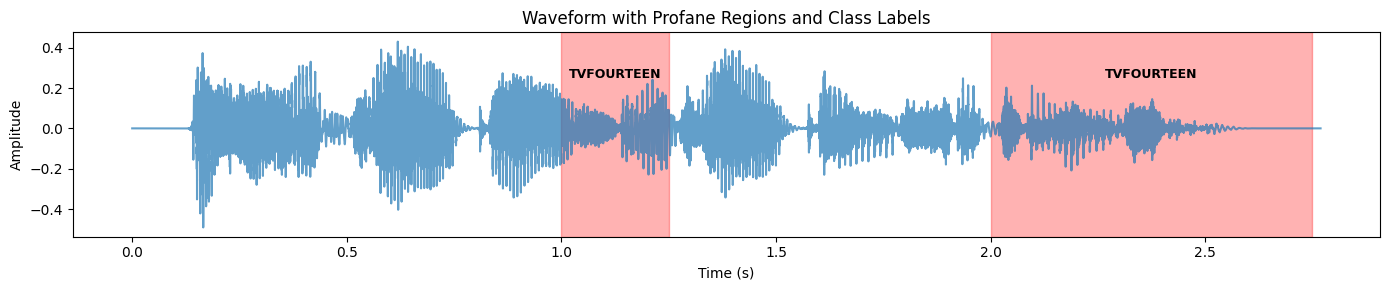

[(1.0, 1.25, 'TVFOURTEEN'), (2.0, 2.75, 'TVFOURTEEN')]

In [148]:
visualize_profane_regions(
    audio_path=r"Unseen audio\Tanvir\2424_profane.mp3",
    window_size_sec=0.25,
    stride_sec=0.25,
    threshold=0.6,
)

In [ ]:
from pydub import AudioSegment
from pydub.generators import Sine

def beep_censor_audio(input_audio_path, output_audio_path, regions_to_censor, beep_duration_ms=500):
    """
    Censors specified regions in an audio file with a beep sound.

    Args:
        input_audio_path (str): Path to the original audio file.
        output_audio_path (str): Path to save the censored audio file.
        regions_to_censor (list): A list of tuples, where each tuple is (start_sec, end_sec)
                                  representing the start and end time of the region to censor in seconds.
        beep_duration_ms (int): Duration of the beep sound in milliseconds.
    """
    try:
        audio = AudioSegment.from_file(input_audio_path)
    except Exception as e:
        print(f"Error loading audio file {input_audio_path}: {e}")
        return

    sample_rate = audio.frame_rate
    beep_freq = 1000 # Hz, typical beep sound

    # Create a beep sound (adjust frequency and volume as needed)
    beep_segment = Sine(beep_freq).to_audio_segment(duration=beep_duration_ms).set_frame_rate(sample_rate)

    for start_sec, end_sec in regions_to_censor:
        start_ms = int(start_sec * 1000)
        end_ms = int(end_sec * 1000)

        # Ensure the beep segment is long enough or tile it
        duration_of_censor_region_ms = end_ms - start_ms
        if beep_segment.duration_milliseconds < duration_of_censor_region_ms:
            # Tile the beep segment to cover the entire duration
            num_repeats = (duration_of_censor_region_ms + beep_segment.duration_milliseconds - 1) // beep_segment.duration_milliseconds
            current_beep = beep_segment * num_repeats
            current_beep = current_beep[:duration_of_censor_region_ms] # Trim to exact length
        else:
            current_beep = beep_segment[:duration_of_censor_region_ms] # Trim if longer than needed

        # Replace the audio segment with the beep
        audio = audio.overlay(current_beep, position=start_ms)

    try:
        # Ensure the output directory exists
        output_dir = os.path.dirname(output_audio_path)
        os.makedirs(output_dir, exist_ok=True)
        audio.export(output_audio_path, format="mp3")
        print(f"Censored audio saved to: {output_audio_path}")
    except Exception as e:
        print(f"Error saving censored audio to {output_audio_path}: {e}")

Final Profane Regions (seconds):
  1.00s → 1.25s   Label: TVFOURTEEN
  2.00s → 2.75s   Label: TVFOURTEEN


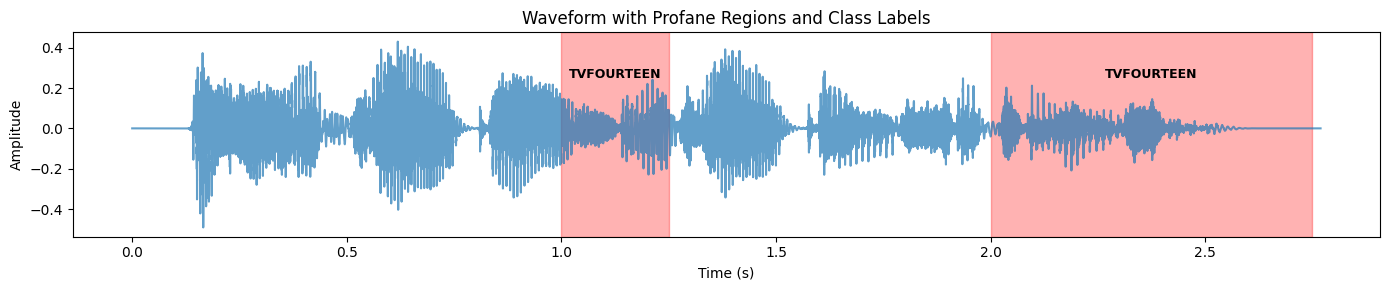

Error loading audio file Unseen audio\Tanvir\2424_profane.mp3: [WinError 2] The system cannot find the file specified


In [152]:
# Step 3: Run visualization + censor in one flow
audio_path = r"Unseen audio\Tanvir\2424_profane.mp3"
output_path = r"Output"

# Step 1: Visualize and extract merged profane regions
regions_with_labels = visualize_profane_regions(
    audio_path=audio_path, window_size_sec=0.25, stride_sec=0.25, threshold=0.6
)

# Step 2: Prepare just (start, end) for beeping
censored_regions = [(start, end) for start, end, _ in regions_with_labels]

# Step 3: Beep those regions and export new file
beep_censor_audio(audio_path, output_path, censored_regions)  # type: ignore

In [153]:
resnet.load_state_dict(torch.load("resnet_18_with_profane_nonProfane.pth", map_location=device))
resnet.eval() # Set the model to evaluation mode

all_true_labels = []
all_predictions = []

with torch.no_grad(): # Disable gradient calculation for inference
    for inputs, targets in tqdm(test_loader, desc="Evaluating model"):
        inputs = inputs.to(device)
        targets = targets.to(device)

        outputs = resnet(inputs)
        # Apply sigmoid and threshold to get binary predictions for multi-label classification
        predicted = (torch.sigmoid(outputs) > 0.6).cpu().numpy()

        all_true_labels.extend(targets.cpu().numpy())
        all_predictions.extend(predicted)

all_true_labels = np.array(all_true_labels)
all_predictions = np.array(all_predictions)

print(f"Collected {len(all_true_labels)} true label samples and {len(all_predictions)} prediction samples.")
print(f"Shape of collected true labels: {all_true_labels.shape}")
print(f"Shape of collected predictions: {all_predictions.shape}")

Evaluating model: 100%|██████████| 22/22 [00:05<00:00,  4.02it/s]

Collected 342 true label samples and 342 prediction samples.
Shape of collected true labels: (342, 3)
Shape of collected predictions: (342, 3)


--- Multilabel Confusion Matrices (one for each class) ---

Confusion Matrix for label: 'TVFOURTEEN'
[[227  25]
 [ 30  60]]
  True Negative (TN): 227
  False Positive (FP): 25
  False Negative (FN): 30
  True Positive (TP): 60


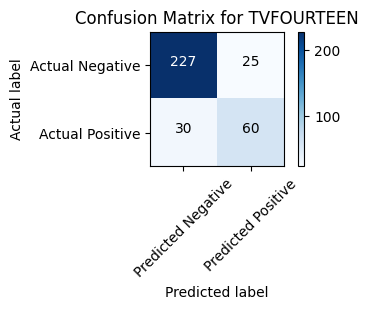


Confusion Matrix for label: 'TVMA'
[[252  14]
 [ 26  50]]
  True Negative (TN): 252
  False Positive (FP): 14
  False Negative (FN): 26
  True Positive (TP): 50


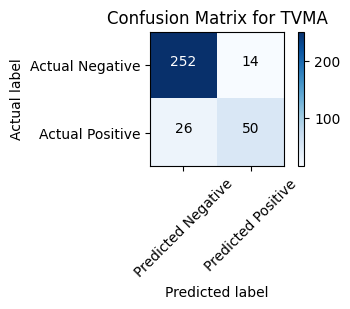


Confusion Matrix for label: 'TVYSEVEN'
[[252  29]
 [ 28  33]]
  True Negative (TN): 252
  False Positive (FP): 29
  False Negative (FN): 28
  True Positive (TP): 33


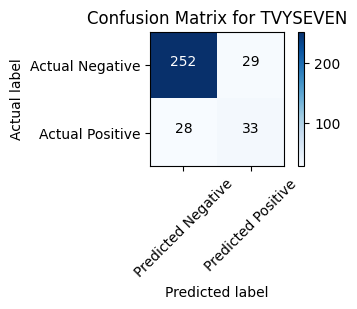


--- Classification Report ---
              precision    recall  f1-score   support

  TVFOURTEEN       0.71      0.67      0.69        90
        TVMA       0.78      0.66      0.71        76
    TVYSEVEN       0.53      0.54      0.54        61

   micro avg       0.68      0.63      0.65       227
   macro avg       0.67      0.62      0.65       227
weighted avg       0.68      0.63      0.66       227
 samples avg       0.31      0.32      0.30       227


--- Overall Binary Confusion Matrix (Profane vs. Non-Profane) ---
Labels: 0 = Non-Profane, 1 = Profane
[[164   5]
 [ 28 145]]


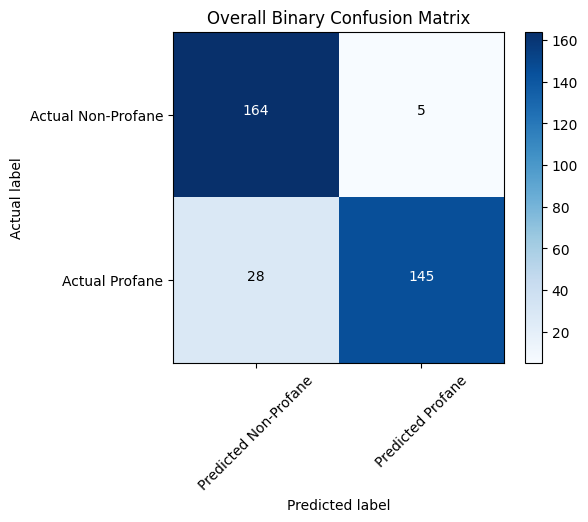

In [154]:
from sklearn.metrics import (
    multilabel_confusion_matrix,
    confusion_matrix,
    classification_report,
)
import matplotlib.pyplot as plt
import numpy as np

class_names = mlb.classes_

mlcm = multilabel_confusion_matrix(all_true_labels, all_predictions)

print("--- Multilabel Confusion Matrices (one for each class) ---")
for i, cm in enumerate(mlcm):
    label = class_names[i]
    print(f"\nConfusion Matrix for label: '{label}'")
    print(cm)
    print(f"  True Negative (TN): {cm[0, 0]}")
    print(f"  False Positive (FP): {cm[0, 1]}")
    print(f"  False Negative (FN): {cm[1, 0]}")
    print(f"  True Positive (TP): {cm[1, 1]}")

    # Visualize each confusion matrix using matplotlib
    plt.figure(figsize=(4, 3))
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {label}")
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ["Predicted Negative", "Predicted Positive"], rotation=45)
    plt.yticks(tick_marks, ["Actual Negative", "Actual Positive"])
    plt.tight_layout()
    plt.ylabel("Actual label")
    plt.xlabel("Predicted label")

    # Add text annotations
    thresh = cm.max() / 2.0
    for i_row in range(cm.shape[0]):
        for j_col in range(cm.shape[1]):
            plt.text(
                j_col,
                i_row,
                format(cm[i_row, j_col], "d"),
                horizontalalignment="center",
                color="white" if cm[i_row, j_col] > thresh else "black",
            )
    plt.show()


# Additionally, print a classification report for overall metrics
print("\n--- Classification Report ---")
print(classification_report(all_true_labels, all_predictions, target_names=class_names))

# Overall Binary Confusion Matrix (Profane vs. Non-Profane)
is_profane_true = (all_true_labels.sum(axis=1) > 0).astype(int)
is_profane_pred = (all_predictions.sum(axis=1) > 0).astype(int)

cm_overall_binary = confusion_matrix(is_profane_true, is_profane_pred)

print("\n--- Overall Binary Confusion Matrix (Profane vs. Non-Profane) ---")
print("Labels: 0 = Non-Profane, 1 = Profane")
print(cm_overall_binary)

plt.figure(figsize=(6, 5))
plt.imshow(cm_overall_binary, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Overall Binary Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Predicted Non-Profane", "Predicted Profane"], rotation=45)
plt.yticks(tick_marks, ["Actual Non-Profane", "Actual Profane"])
plt.tight_layout()
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

# Add text annotations
thresh = cm_overall_binary.max() / 2.0
for i_row in range(cm_overall_binary.shape[0]):
    for j_col in range(cm_overall_binary.shape[1]):
        plt.text(
            j_col,
            i_row,
            format(cm_overall_binary[i_row, j_col], "d"),
            horizontalalignment="center",
            color="white" if cm_overall_binary[i_row, j_col] > thresh else "black",
        )
plt.show()

In [162]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

overall_correct_predictions = (all_predictions == all_true_labels).sum()
overall_total_elements = (
    all_true_labels.size
)  # total number of labels across all samples


micro_f1 = f1_score(all_true_labels, all_predictions, average="micro") * 100
print(f"Micro-averaged F1 Score (Test Set): {micro_f1:.2f}%")

try:
    overall_binary_accuracy = accuracy_score(is_profane_true, is_profane_pred) * 100
    print(
        f"Overall Binary (Profane vs. Non-Profane) Accuracy (Test Set): {overall_binary_accuracy:.2f}%"
    )
except NameError:
    print(
        "\nNote: Overall Binary Accuracy requires 'is_profane_true' and 'is_profane_pred' from the confusion matrix cell to be run first."
    )

Micro-averaged F1 Score (Test Set): 65.30%
Overall Binary (Profane vs. Non-Profane) Accuracy (Test Set): 90.35%
